In [1]:
glob_path = '/opt/iui-datarelease2-sose2021/*/split_letters_csv/*'

pickle_file = 'data.pickle'

In [2]:
from glob import glob
import pandas as pd
from tqdm import tqdm

def dl_from_blob(filename) -> list:
    all_data = []
    
    for path in tqdm(glob(filename)):
        path = path
        df = pd.read_csv(path, ';')
        u = path.split('/')[3]
        l = ''.join(filter(lambda x: x.isalpha(), path.split('/')[5]))[0] 
        d = {
            'file': path,
            'data': df,
            'user': u,
            'label': l
        }
        all_data.append(d)
    return all_data

In [3]:
def save_pickle(f, structure):
    _p = open(f, 'wb')
    pickle.dump(structure, _p)
    _p.close()

In [4]:
import pickle

def load_pickles(f) -> list:
    _p = open(pickle_file, 'rb')
    _d = pickle.load(_p)
    _p.close()
    
    return _d

In [5]:
import os
def load_data() -> list:
    if os.path.isfile(pickle_file):
        print(f'{pickle_file} found...')
        return load_pickles(pickle_file)
    print(f'Didn\'t find {pickle_file}...')
    all_data = dl_from_blob(glob_path)
    print(f'Creating {pickle_file}...')
    save_pickle(pickle_file, all_data)
    return all_data

print("Loading data...")
data = load_data()
# plot_pd(data[0]['data'], False)

Loading data...
data.pickle found...


In [6]:
import matplotlib.pyplot as plt

def plot_pd(data, force=True):
    fig, axs = plt.subplots(5, 3, figsize=(3*3, 3*5))
    axs[0][0].plot(data['Acc1 X'])
    axs[0][1].plot(data['Acc1 Y'])
    axs[0][2].plot(data['Acc1 Z'])
    axs[1][0].plot(data['Acc2 X'])
    axs[1][1].plot(data['Acc2 Y'])
    axs[1][2].plot(data['Acc2 Z'])
    axs[2][0].plot(data['Gyro X'])
    axs[2][1].plot(data['Gyro Y'])
    axs[2][2].plot(data['Gyro Z'])
    axs[3][0].plot(data['Mag X'])
    axs[3][1].plot(data['Mag Y'])
    axs[3][2].plot(data['Mag Z'])
    axs[4][0].plot(data['Time'])

    if force:
        for a in axs:
            for b in a:
                b.plot(data['Force'])
    else:
        axs[4][1].plot(data['Force'])

def plot_np(data, force=True):
    fig, axs = plt.subplots(5, 3, figsize=(3*3, 3*5))
    axs[0][0].plot(data[0])
    axs[0][1].plot(data[1])
    axs[0][2].plot(data[2])
    axs[1][0].plot(data[3])
    axs[1][1].plot(data[4])
    axs[1][2].plot(data[5])
    axs[2][0].plot(data[6])
    axs[2][1].plot(data[7])
    axs[2][2].plot(data[8])
    axs[3][0].plot(data[9])
    axs[3][1].plot(data[10])
    axs[3][2].plot(data[11])
    axs[4][0].plot(data[13])

    if force:
        for a in axs:
            for b in a:
                b.plot(data[12])
    else:
        axs[4][1].plot(data[12])


In [7]:
def mill_drop(entry):
    #drop millis on single
    data_wo_mill = entry['data'].drop(labels='Millis', axis=1, inplace=False)
    drop_entry = entry
    drop_entry['data'] = data_wo_mill.reset_index(drop=True)
    
    return drop_entry

In [8]:
import numpy as np

def cut_force(drop_entry):
    # force trans
    shorten_entry = drop_entry
    shorten_data = shorten_entry['data']
    sf_entry = shorten_data['Force']
    leeway = 10
    
    try:
        thresh = 70
        temps_over_T = np.where(sf_entry > thresh)[0]
        shorten_data = shorten_data[max(temps_over_T.min()-leeway,0):min(len(sf_entry)-1,temps_over_T.max()+leeway)]
    except:
        thresold = 0.05
        thresh = sf_entry.max()*thresold
        temps_over_T = np.where(sf_entry > thresh)[0]
        shorten_data = shorten_data[max(temps_over_T.min()-leeway,0):min(len(sf_entry)-1,temps_over_T.max()+leeway)]
    
    shorten_entry['data'] = shorten_data.reset_index(drop=True)
    return shorten_entry

In [9]:
def norm_force(shorten_entry, flist):
    fnorm_entry = shorten_entry
    u = fnorm_entry['user']
    d = fnorm_entry['data']
    
    
    d['Force'] = ((d['Force'] - flist[u].mean())/flist[u].std())
    
    fnorm_entry['data'] = fnorm_entry['data'].reset_index(drop=True)
    return fnorm_entry

In [10]:
def time_trans(fnorm_entry):
    #timetrans
    time_entry = fnorm_entry
    
    time_entry['data']['Time'] = fnorm_entry['data']['Time']-fnorm_entry['data']['Time'][0]
    
    time_entry['data'] = time_entry['data'].reset_index(drop=True)

    return time_entry

In [11]:
def norm(time_entry):
    # normalize
    norm_entry = time_entry
    
    norm_entry['data']['Acc1 X'] = norm_entry['data']['Acc1 X'] / 32768
    norm_entry['data']['Acc1 Y'] = norm_entry['data']['Acc1 Y'] / 32768
    norm_entry['data']['Acc1 Z'] = norm_entry['data']['Acc1 Z'] / 32768
    norm_entry['data']['Acc2 X'] = norm_entry['data']['Acc2 X'] / 8192
    norm_entry['data']['Acc2 Y'] = norm_entry['data']['Acc2 Y'] / 8192
    norm_entry['data']['Acc2 Z'] = norm_entry['data']['Acc2 Z'] / 8192
    norm_entry['data']['Gyro X'] = norm_entry['data']['Gyro X'] / 32768
    norm_entry['data']['Gyro Y'] = norm_entry['data']['Gyro Y'] / 32768
    norm_entry['data']['Gyro Z'] = norm_entry['data']['Gyro Z'] / 32768
    norm_entry['data']['Mag X']  = norm_entry['data']['Mag X']  / 8192
    norm_entry['data']['Mag Y']  = norm_entry['data']['Mag Y']  / 8192
    norm_entry['data']['Mag Z']  = norm_entry['data']['Mag Z']  / 8192
#     norm_entry['data']['Mag Z']  = norm_entry['data']['Mag Z']  / 4096
    
    norm_entry['data'] = norm_entry['data'].reset_index(drop=True)
    
    return norm_entry

In [12]:
def preproc(d):
    flist = {}  
    d_res = []
    for e in data:
        if e['user'] not in flist:
            flist[e['user']] = e['data']['Force']
        else:
            flist[e['user']] = flist[e['user']].append(e['data']['Force'])
    
    for e in tqdm(data):
        d_res.append(preproc_entry(e, flist))
    return d_res
    
def preproc_entry(entry, flist):
    drop_entry = mill_drop(entry)
#     plot_pd(drop_entry['data'])
#     
    shorten_entry = cut_force(drop_entry)
#     plot_pd(shorten_entry['data'])
#     
    fnorm_entry = norm_force(shorten_entry, flist)
#     plot_pd(fnorm_entry['data'])
#     
    time_entry = time_trans(shorten_entry)
#     plot_pd(time_entry['data'])
#     
    norm_entry = norm(time_entry)
#     plot_pd(norm_entry['data'], False)
    return norm_entry

print("Preprocessing...")
pdata = preproc(data)
# plot_pd(pdata[0]['data'], False)

In [13]:
def throw(pdata):
    llist = pd.Series([len(x['data']) for x in pdata])
    threshold = int(llist.quantile(threshold_p))
    longdex = np.where(llist <= threshold)[0]
    return np.array(pdata)[longdex]

llist = pd.Series([len(x['data']) for x in pdata])
threshold_p = 0.75
threshold = int(llist.quantile(threshold_p))

print("Truncating...")
tpdata = throw(pdata)
# plot_pd(tpdata[0]['data'], False)

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# ltpdata = []
def elong(tpdata):
    for x in tqdm(tpdata):
        y = x['data'].to_numpy().T
        x['data'] = pad_sequences(y, dtype=float, padding='post', maxlen=threshold)
    return tpdata

print("Padding...")
ltpdata = elong(tpdata)
# plot_np(ltpdata[0]['data'], False)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D


def build_model():
    model = Sequential()
    ncount = train_shape[0]*train_shape[1]
    
#     model.add(Conv2D(64, (5, 5), input_shape=train_shape, activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    
#     model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten(input_shape=train_shape))
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.1))
    
    for i in range(2,5):
        model.add(Dense(int(ncount/i), activation='relu'))
        model.add(Dropout(0.1))
    
    model.add(Dense(classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss="categorical_crossentropy", 
        metrics=["acc"],
    )

    return model

In [16]:
checkpoint_file = './goat.weights'

def train(X_train, y_train, X_test, y_test):
    model = build_model()
    
    model.summary()
    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_file,
        save_weights_only=True,
        monitor='val_acc',
        mode='max',
        save_best_only=True
    )
    
    model.fit(X_train, y_train, 
              epochs=30,
              batch_size=256,
              shuffle=True,
              validation_data=(X_test, y_test),
              verbose=1,
              callbacks=[model_checkpoint_callback]
             )
    
    print("Evaluate on test data")
    results = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
    print("test loss, test acc:", results)

In [17]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # this is required
os.environ['CUDA_VISIBLE_DEVICES'] = '0'         # set to '0' for GPU0, '1' for GPU1 or '2' for GPU2. Check "gpustat" in a terminal.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

X = np.array([x['data'] for x in ltpdata])
y = np.array([x['label'] for x in ltpdata])

lb = LabelBinarizer()
y_tran = lb.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_tran, test_size=0.2, random_state=177013)

X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

train_shape = X_train[0].shape
classes = y_train[0].shape[0]

In [24]:
print("Training...")
train(X_train, y_train, X_test, y_test)

Training...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 75, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 37, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 37, 64)         102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3456)              13824     
_________________________________________________________________
dropout (Dropout)            (None, 3456)   

In [26]:
train_shape, classes

((14, 75, 1), 52)

In [27]:
X_train[0].shape

(14, 75, 1)

In [28]:
d = data[0]['data'].reshape(1,data[0]['data'].shape[0], data[0]['data'].shape[1], X_train[0].shape[2])
pd.DataFrame(d.reshape(d.shape[1], d.shape[2]).T)
dd = d.reshape(d.shape[1], d.shape[2])


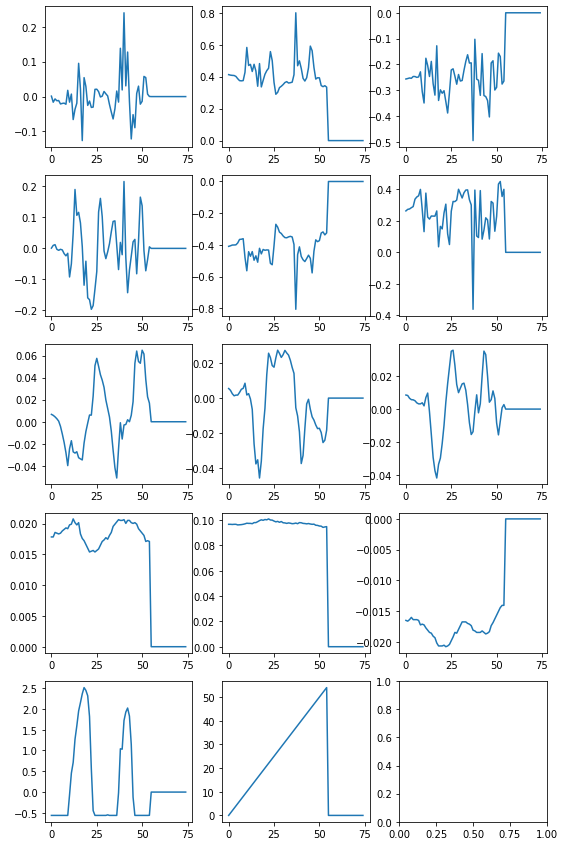

In [29]:
def pplot(dd):
    x = dd.shape[0]
    fix = int(x/3)+1
    fiy = 3
    fig, axs = plt.subplots(fix, fiy, figsize=(3*fiy, 3*fix))
    
    for i in range(x):
        axs[int(i/3)][i%3].plot(dd[i])
        
pplot(dd)

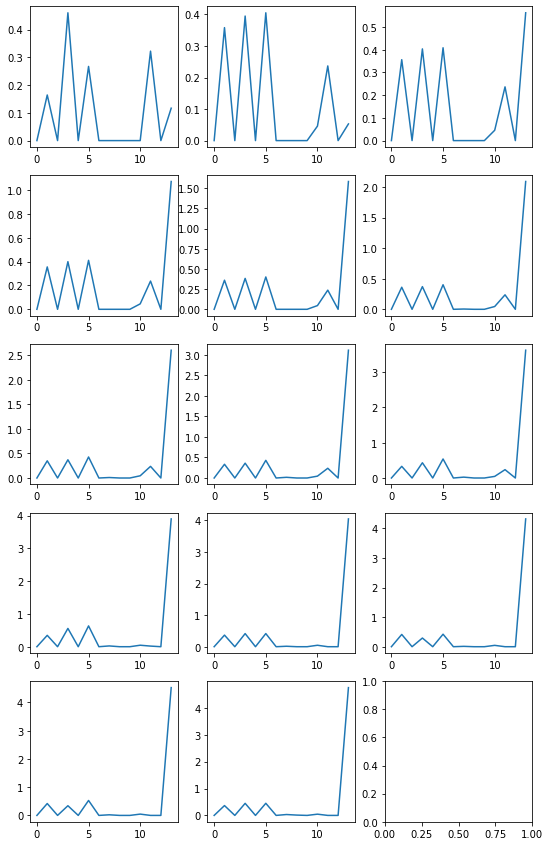

In [30]:
conv = Conv2D(1, (3,3), input_shape=train_shape, activation='relu', padding='same')
c = conv(d)
cc = pd.DataFrame(c.numpy().reshape(d.shape[1], d.shape[2]))

pplot(cc)

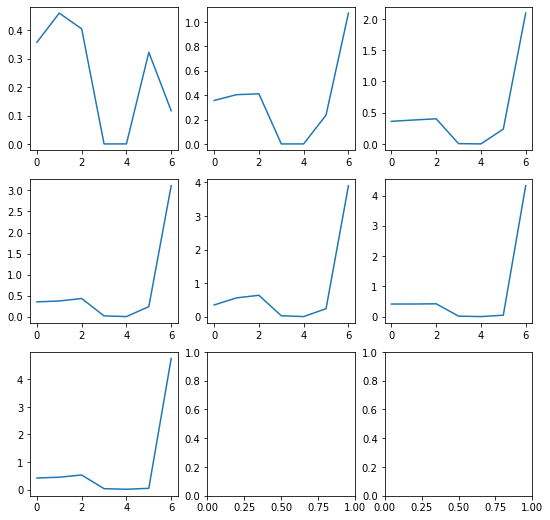

In [31]:
pol = MaxPooling2D(pool_size=(2, 2))
p = pol(c)
pp = pd.DataFrame(p.numpy().reshape(p.shape[1], p.shape[2]))
pplot(pp)

In [32]:
pd.DataFrame(d.reshape(X_train[0].shape[0], X_train[0].shape[1]).T)

0         1         2         3         4         5         6   \
0   0.001282  0.412811 -0.256378  0.000854 -0.409180  0.262451  0.006683   
1  -0.016144  0.409729 -0.254547  0.009766 -0.405640  0.272217  0.005798   
2  -0.006683  0.408264 -0.252441  0.011963 -0.401001  0.274780  0.004425   
3  -0.011963  0.407440 -0.253662 -0.002930 -0.400635  0.282837  0.002716   
4  -0.011292  0.401672 -0.246674 -0.006226 -0.399658  0.289795  0.000549   
..       ...       ...       ...       ...       ...       ...       ...   
70  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
71  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
72  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
73  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
74  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          7         8         9         10        11        12   13  
0   0.005463  0.008514  0.017822  0.096680 -0.016479 -0.561079  0.0  
1   0.004425  0.008240  0.017822  0.096680 -0.016602 -0.561079  1.0  
2   0.002502  0.006561  0.018555  0.096558 -0.016357 -0.561079  2.0  
3   0.001312  0.005707  0.018433  0.096680 -0.015991 -0.561079  3.0  
4   0.001709  0.005615  0.018311  0.096680 -0.016357 -0.561079  4.0  
..       ...       ...       ...       ...       ...       ...  ...  
70  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  
71  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  
72  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  
73  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  
74  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  

[75 rows x 14 columns]

In [33]:
pd.DataFrame(c.numpy().reshape(c.shape[1], c.shape[2]).T)

0         1    2         3    4         5    6    7    8    9         10  \
0   0.0  0.164418  0.0  0.460755  0.0  0.267381  0.0  0.0  0.0  0.0  0.000000   
1   0.0  0.358112  0.0  0.394801  0.0  0.405149  0.0  0.0  0.0  0.0  0.045922   
2   0.0  0.356213  0.0  0.403690  0.0  0.408704  0.0  0.0  0.0  0.0  0.045495   
3   0.0  0.355599  0.0  0.399693  0.0  0.410803  0.0  0.0  0.0  0.0  0.045657   
4   0.0  0.360133  0.0  0.382545  0.0  0.400446  0.0  0.0  0.0  0.0  0.045980   
..  ...       ...  ...       ...  ...       ...  ...  ...  ...  ...       ...   
70  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000   
71  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000   
72  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000   
73  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000   
74  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000   

          11   12        13  
0   0.322476  0.0  0.116835  
1   0.236685  0.0  0.052844  
2   0.236544  0.0  0.562665  
3   0.236834  0.0  1.072485  
4   0.237183  0.0  1.582306  
..       ...  ...       ...  
70  0.000000  0.0  0.000000  
71  0.000000  0.0  0.000000  
72  0.000000  0.0  0.000000  
73  0.000000  0.0  0.000000  
74  0.000000  0.0  0.000000  

[75 rows x 14 columns]